In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

def process_frame(frame):

    output = {
        'qid': [],
        'query': [],
        'docno': [],
        'text': [],
        'perturbed': [],
    }

    for row in frame.itertuples():
        output['qid'].append(row.qid)
        output['query'].append(row.query)
        output['docno'].append(row.docno)
        output['text'].append(row.text)
        output['perturbed'].append(row.perturbed_text)
    
    return pd.DataFrame(output)

Matplotlib created a temporary cache directory at /tmp/matplotlib-amw2mp_n because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
FORMATTED_MODEL_NAME = 'crystina-z-monoELECTRA_LCE_nneg31'
MODEL_TYPE = 'cross'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')

In [25]:
score_difference = perturbed_scores - original_scores

patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))

patching_results_normalised_logarithm = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.log(1 + np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
mean_magnitude = np.mean(np.abs(patching_results_normalised), axis=(-2,-1))
variance = np.var(patching_results_normalised, axis=(-2,-1))
std = np.std(patching_results_normalised, axis=(-2,-1))
mean_magnitude_logarithm = np.mean(np.abs(patching_results_normalised_logarithm), axis=(-2,-1))
mean_magnitude_square = np.mean(np.abs(patching_results_normalised_square), axis=(-2,-1))
mean_magnitude_unnormalised = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-2,-1))
std_unnormalised = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
mean_relative_magnitude = np.mean(patching_results_normalised, axis=(-2,-1))
mean_relative_magnitude_unnormalised = np.mean(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
max_relative_magnitude_unnormalised = np.max(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
max_relative_magnitude_square = np.max(patching_results_normalised_square, axis=(-2,-1))
sorted_magnitudes = np.argsort(mean_magnitude)[::-1]
patching_results_normalised_sorted = patching_results_normalised[sorted_magnitudes]

all_data_pd['score_difference_when_patching'] = score_difference
all_data_pd['mean_magnitude'] = mean_magnitude
all_data_pd['mean_magnitude_unnormalised'] = mean_magnitude_unnormalised
all_data_pd['mean_relative_magnitude'] = mean_relative_magnitude
all_data_pd['mean_relative_magnitude_unnormalised'] = mean_relative_magnitude_unnormalised
all_data_pd['max_relative_magnitude_unnormalised'] = max_relative_magnitude_unnormalised

<Axes: >

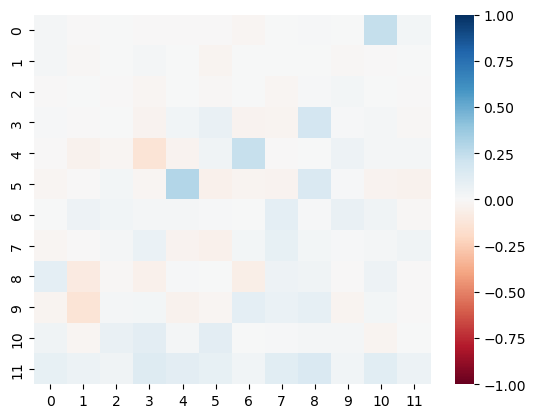

In [17]:
sns.heatmap(
    np.mean(patching_results_normalised, axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

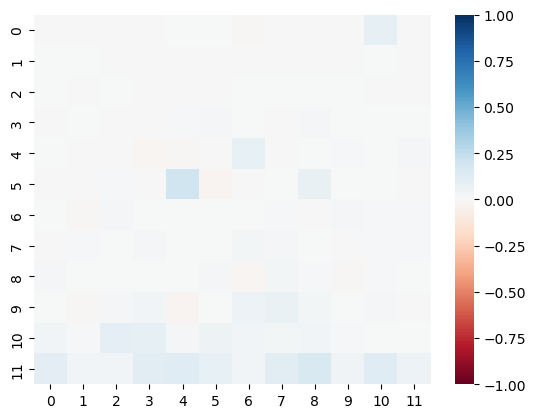

In [18]:
sns.heatmap(
    np.mean(patching_results_normalised[score_difference > 0.05], axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

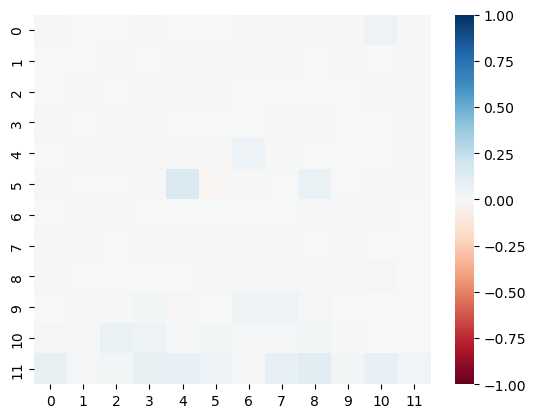

In [19]:
sns.heatmap(
    np.mean(patching_results_normalised_square, axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

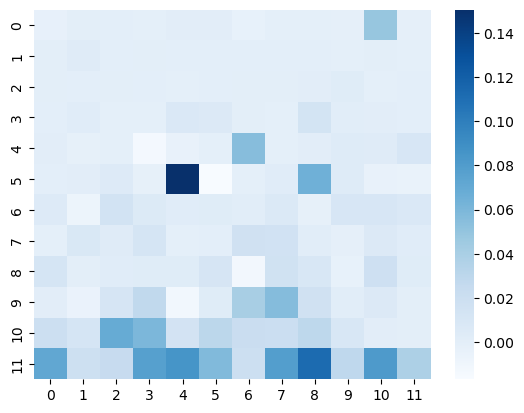

In [20]:
sns.heatmap(
    np.mean(patching_results_normalised_square, axis=0),
    # vmax=1,
    # vmin=-1,
    cmap='Blues'
)

<Axes: >

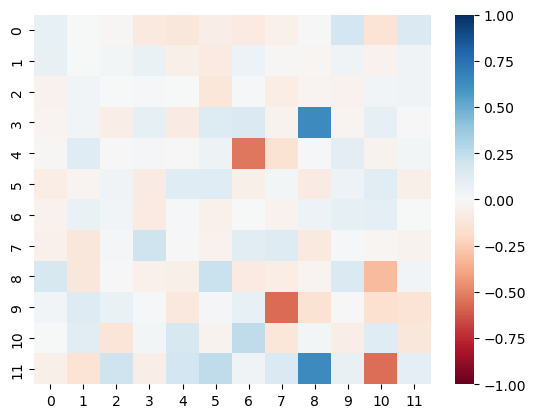

In [21]:
original_patching_results = np.load('/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/crystina-z-monoELECTRA_LCE_nneg31_cross_TFC1_4000_patch_head_all.npy')
sns.heatmap(
    original_patching_results,
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

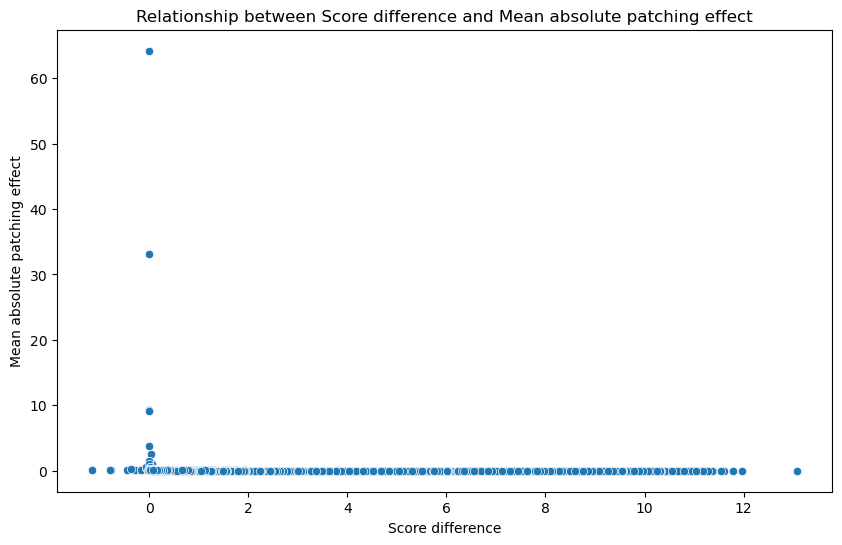

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Relationship between Score difference and Mean absolute patching effect')
plt.show()

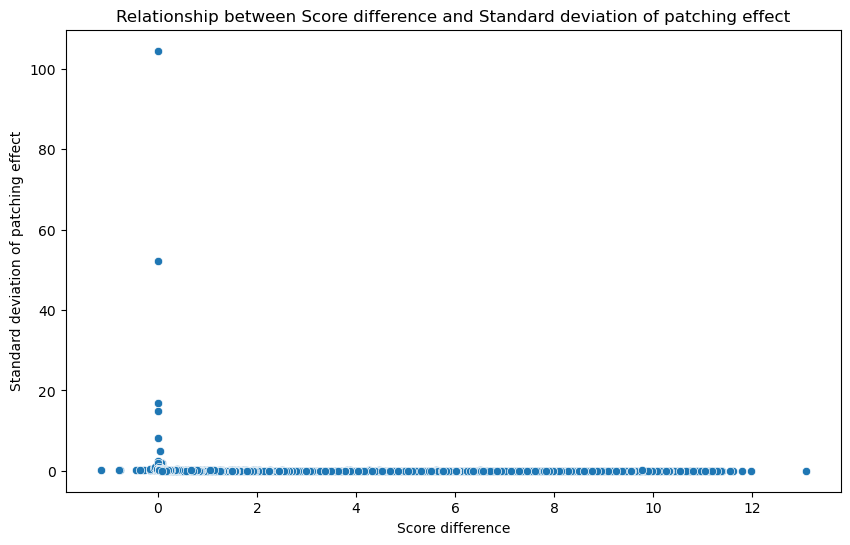

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=std)
plt.xlabel('Score difference')
plt.ylabel('Standard deviation of patching effect')
plt.title(f'Relationship between Score difference and Standard deviation of patching effect')
plt.show()

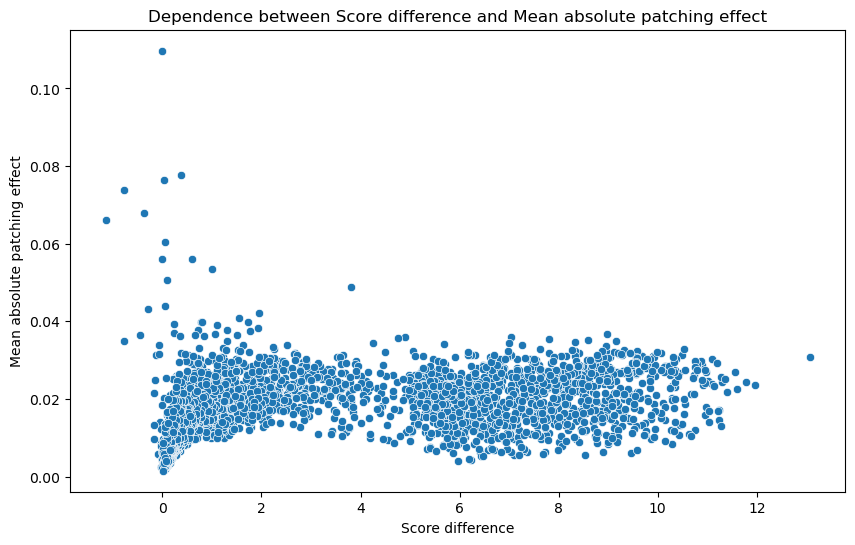

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude_square)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

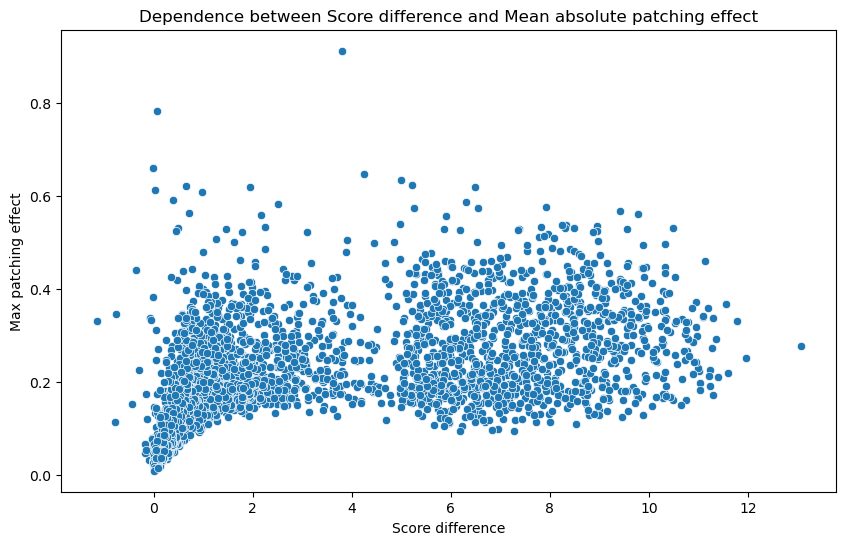

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=max_relative_magnitude_square)
plt.xlabel('Score difference')
plt.ylabel('Max patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

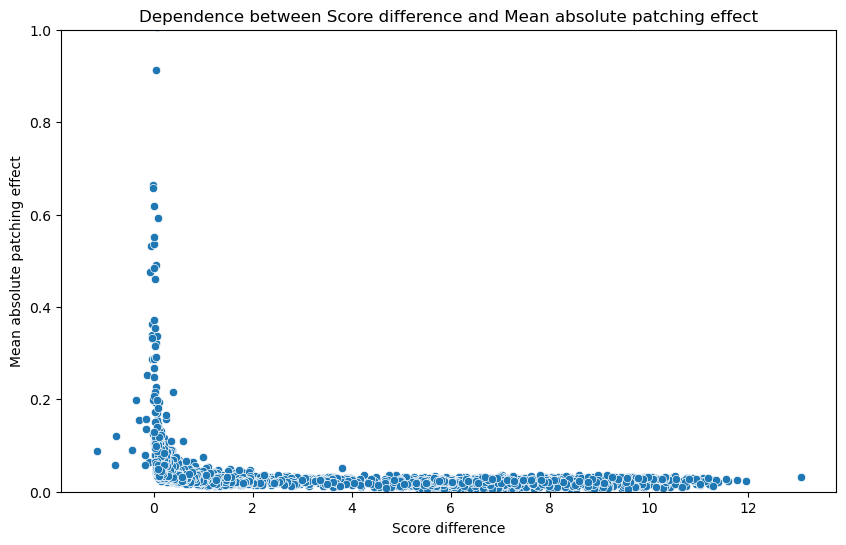

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.ylim(0,1)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

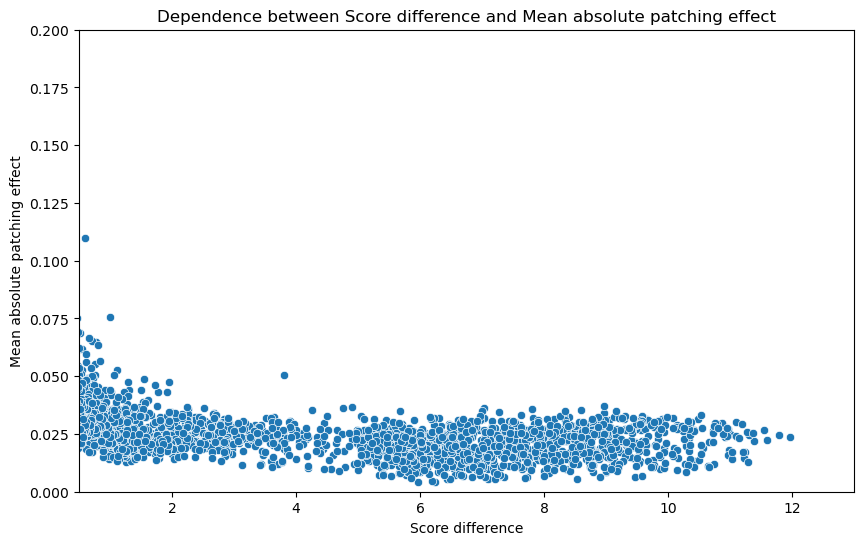

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.xlim(0.5, 13)
plt.ylim(0, 0.2)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

Let's test how does the difference between the patched score and original score depends on the difference between the perturbed score and original score

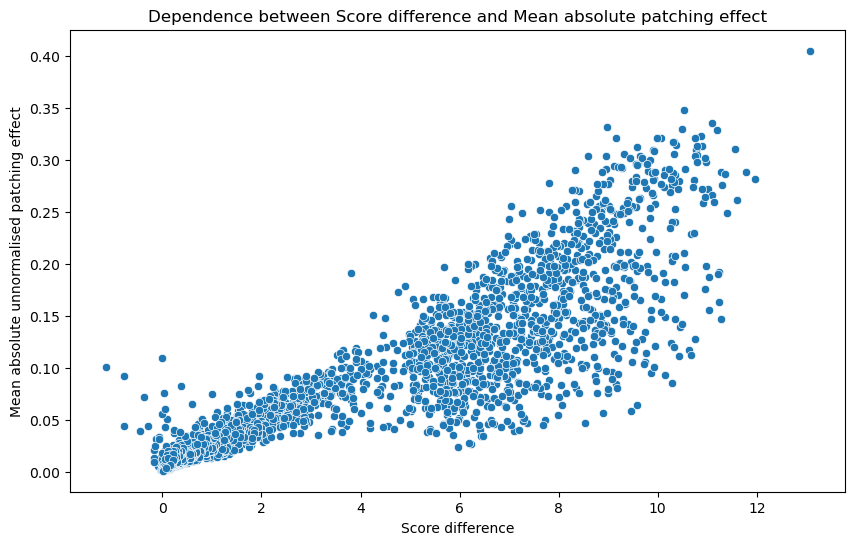

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

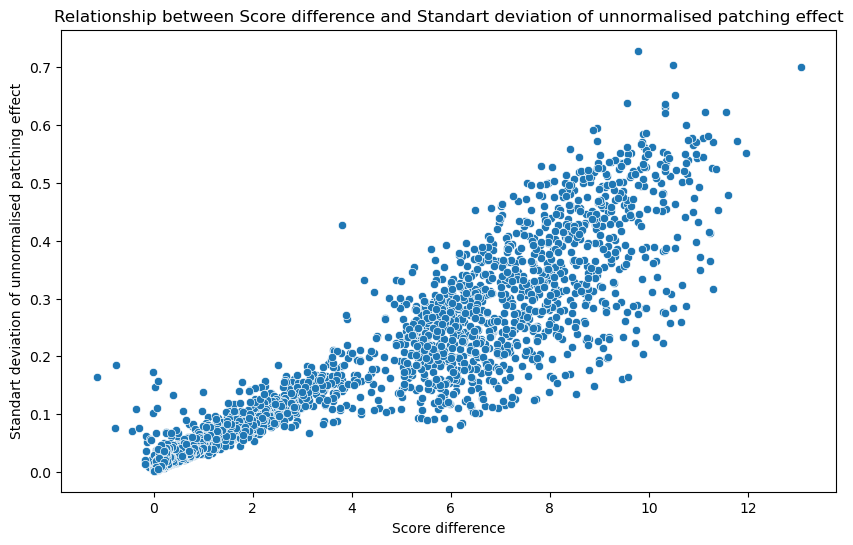

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=std_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Standart deviation of unnormalised patching effect')
plt.title(f'Relationship between Score difference and Standart deviation of unnormalised patching effect')
plt.show()

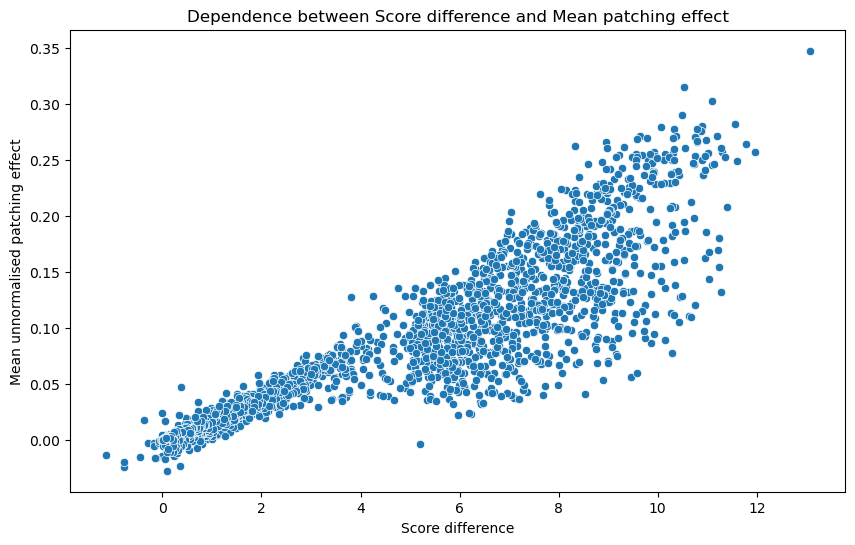

In [57]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_relative_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

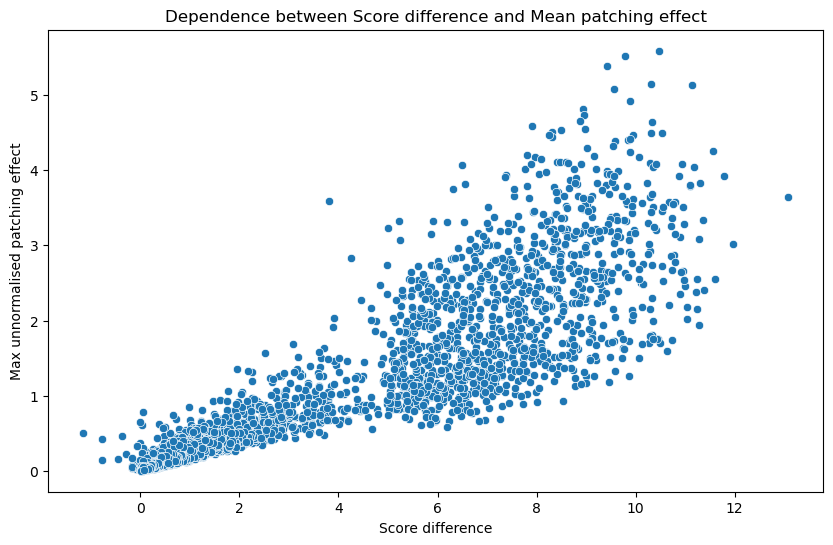

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=max_relative_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Max unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

Let's color these correlation plots according to the qids

In [67]:
qids = all_data_pd['qid'].unique()
colors = plt.cm.get_cmap('tab10', len(qids))
query_color_map = {query: colors(i) for i, query in enumerate(qids)}

/tmp/ipykernel_4012619/1151439420.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(qids))


In [70]:
all_data_pd

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,perturbed_text,score_difference_when_patching,mean_magnitude,mean_magnitude_unnormalised,mean_relative_magnitude,mean_relative_magnitude_unnormalised,max_relative_magnitude_unnormalised
0,855410,what is theraderm used for,7128710,It is used to trap sunlight for the manufactur...,0,True,5.290899,0,-7.387448,12.678347,It is used to trap sunlight for the manufactur...,13.073571,0.031007,0.405368,0.026581,0.347509,3.638302
1,855410,what is theraderm used for,3276027,"A mental grouping of similar things, events, a...",0,True,2.807054,30,-9.529633,12.336688,"A mental grouping of similar things, events, a...",11.963521,0.023562,0.281880,0.021485,0.257041,3.022351
2,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,True,2.844434,26,-9.467996,12.312429,": to add moisture to (something, such as a per...",11.387131,0.021857,0.248891,0.018280,0.208153,2.404328
3,855410,what is theraderm used for,2945339,1 used to form adjectives Resembling or imitat...,0,True,2.434965,38,-9.695806,12.130772,1 used to form adjectives Resembling or imitat...,11.298519,0.024456,0.276316,0.022719,0.256693,3.823480
4,583468,what carvedilol used for,129686,Bottles of eau de toilette. Eau de toilette (F...,0,True,1.873736,226,-10.083253,11.956989,Bottles of eau de toilette. Eau de toilette (F...,11.599349,0.022573,0.261826,0.021466,0.248994,2.552036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,405163,is caffeine an narcotic,7339772,Combination or cocktail drugs that contain a c...,3,True,-4.797085,258,-4.803654,0.006569,Combination or cocktail drugs that contain a c...,0.205678,0.057438,0.011814,0.000811,0.000167,0.051003
3996,324585,how much money do motivational speakers make,405281,Fee structures for more experienced and profes...,3,True,2.972391,8,2.965918,0.006473,Fee structures for more experienced and profes...,0.155103,0.044224,0.006859,0.014864,0.002305,0.035813
3997,1132532,average annual income data analyst,6117745,What Data Analysts Make. Since the field of da...,3,True,2.125537,69,2.119307,0.006230,What Data Analysts Make. Since the field of da...,0.048821,0.099858,0.004875,0.015155,0.000740,0.053746
3998,1113256,what is reba mcentire's net worth,7561111,Reba McEntire is a popular American singer wit...,3,True,5.698447,7,5.692532,0.005915,Reba McEntire is a popular American singer wit...,0.011565,0.129679,0.001500,0.007633,0.000088,0.008489


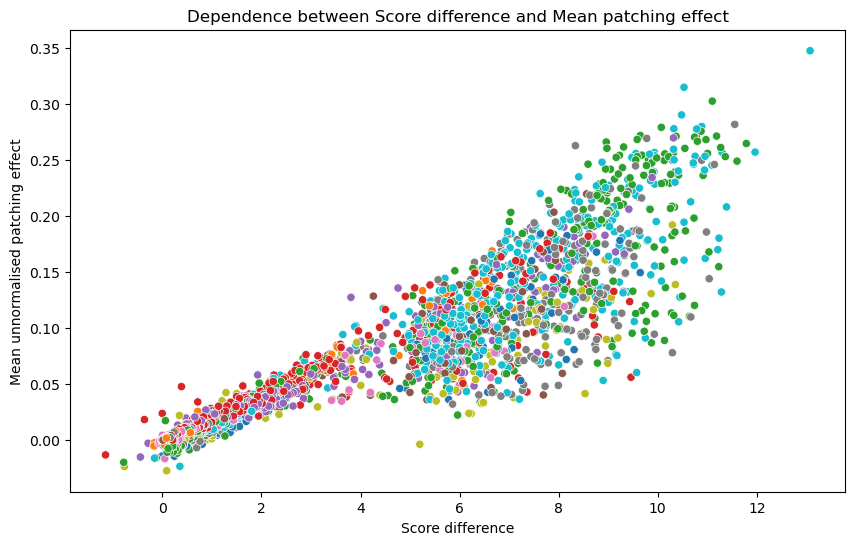

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='qid', palette='tab10', legend=False)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

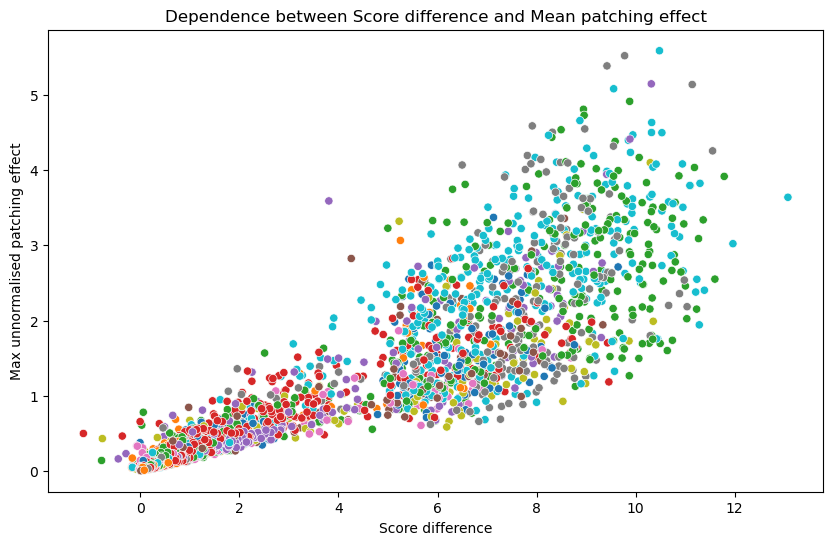

In [72]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='max_relative_magnitude_unnormalised', hue='qid', palette='tab10', legend=False)
plt.xlabel('Score difference')
plt.ylabel('Max unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

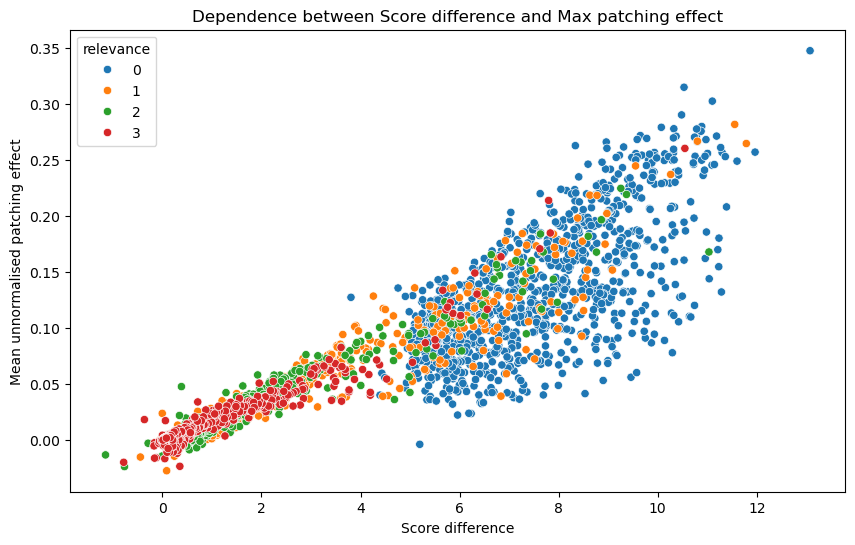

In [79]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Max patching effect')
plt.show()

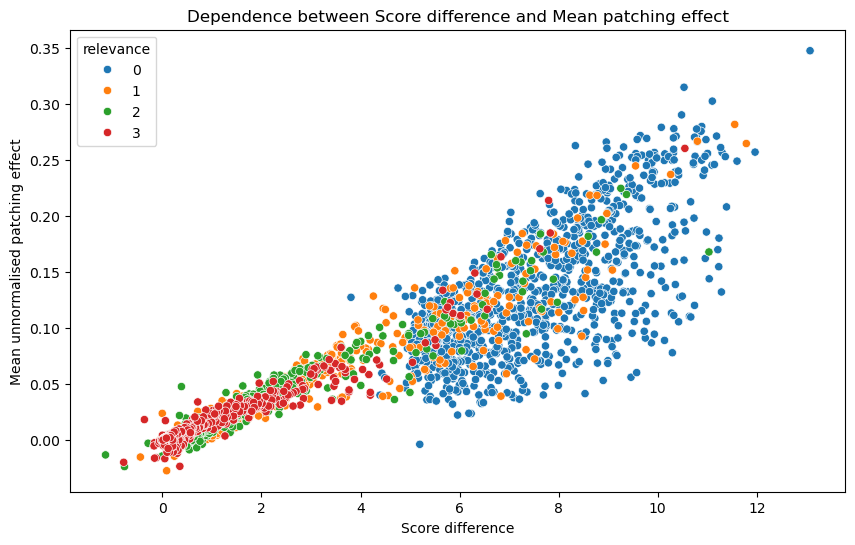

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()